# Exploratory Data Analysis

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

### Import Data Set

In [2]:
df = pd.read_csv('../data/clean/tanzania.csv')

In [3]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,target
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0


In [4]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'target'],
      dtype='object')

In [5]:
df.sample(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,target
26640,69340,0.0,2013-03-21,Tcrs,1715,TCRS,37.944172,-4.459954,Kwa Eliakunda,0,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,non functional,2


### Which water sources tend to be more functional
This column seems to show strong indicators of functionality

In [6]:
# list of different 'status_group' available. used as column names
columns = ['source'] + [ title.replace(' ', '_') for title in df['status_group'].unique().tolist() ] 

water_sources_df = pd.DataFrame(columns=columns)

for source in df['source'].unique().tolist():
    counts = df[df['source'] == source]['status_group'].value_counts(normalize=True)
    row = { columns[0]: source, columns[1]: counts['functional'], columns[2]: counts['non functional'], columns[3]: counts['functional needs repair']}
    water_sources_df = water_sources_df.append(row, ignore_index=True)

In [7]:
# show sorted dataframe
water_sources_df.sort_values(['functional', 'functional_needs_repair', 'non_functional'], ascending=False)

,source,functional,non_functional,functional_needs_repair
0,spring,0.622290,0.302744,0.074966
1,rainwater harvesting,0.603922,0.259259,0.136819
4,other,0.594340,0.400943,0.004717
7,hand dtw,0.568650,0.411899,0.019451
6,river,0.568560,0.304411,0.127029
5,shallow well,0.494769,0.448348,0.056883
3,machine dbh,0.489571,0.466095,0.044334
9,unknown,0.484848,0.454545,0.060606
2,dam,0.385671,0.577744,0.036585
8,lake,0.211765,0.772549,0.015686


In [8]:
# removing 'unknown'
water_sources_df = water_sources_df[water_sources_df['source'] != 'unknown']

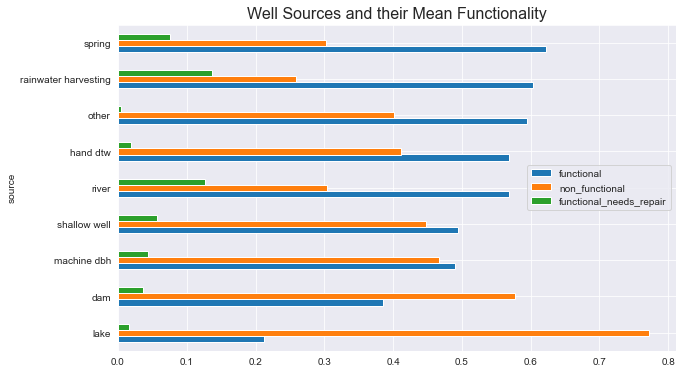

In [9]:
water_sources_df.sort_values(['functional', 'functional_needs_repair', 'non_functional']).set_index('source').plot.barh(figsize=(10, 6))
plt.title('Well Sources and their Mean Functionality', fontsize=16);

### Many of the columns duplicate other columns
Some of the columns are duplicates of each other.

In [10]:
from IPython.core.display import display, HTML

def examine(column_name):
    '''Show a columns name, missing values, and value counts'''
    
    display(HTML(f'''
        <h3>{column_name}</h3>
        <hr>
        <p>Total missing values: {df[column_name].isna().sum()}</p>
        <hr>
        <p>Value Counts:</p>
        '''))
    print(f'{df[column_name].value_counts()}')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [12]:
df.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

### All of these are geographic locations
Do we need them all? Vidya says no!

In [13]:
df.iloc[:, 9:16]

,num_private,basin,subvillage,region,region_code,district_code,lga
0,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa
1,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti
2,0,Pangani,Majengo,Manyara,21,4,Simanjiro
3,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu
4,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe
...,...,...,...,...,...,...,...
59395,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai
59396,0,Rufiji,Igumbilo,Iringa,11,4,Njombe
59397,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali
59398,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino


Drop region_code because its the same as region.

### DO people hang out at the well
Is this a happening well or not.

In [14]:
examine('public_meeting')

True     51011
False     5055
Name: public_meeting, dtype: int64


### Is there a designated person/group to care for well

In [15]:
# does the government permit this well to exist
examine('permit')

True     38852
False    17492
Name: permit, dtype: int64


In [16]:
# who manages the well
examine('scheme_management')

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64


In [17]:
# what company actually performs maintance
examine('scheme_name')

K                             682
None                          644
Borehole                      546
Chalinze wate                 405
M                             400
                             ... 
Mtikanga supply scheme          1
Kitarakakifua water supply      1
Mafi Mountain                   1
Saadani Chumv                   1
Rain water havest               1
Name: scheme_name, Length: 2696, dtype: int64


### Payment does not mean what it says
Payment and payment_type are the same value, and seem to reflect the type more.

In [18]:
# does not mean what it says
examine('payment')

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64


In [19]:
examine('payment_type')

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


Mean functionality by payment type. Lower is better.

In [20]:
df.groupby('payment_type')['target'].mean().sort_values()

payment_type
annually      0.427512
monthly       0.567349
per bucket    0.598887
on failure    0.688043
other         0.728653
never pay     1.026945
unknown       1.082015
Name: target, dtype: float64

### Company/group who installed the pumps

In [21]:
examine('installer')

DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
KURRP                  1
Action Aid             1
Morovian Church        1
Mashaka M              1
HOWARD HUMFREYS        1
Name: installer, Length: 2145, dtype: int64


## Drop irrelevant columns

In [22]:
to_drop = ['id', 'date_recorded', 'wpt_name', 
           'num_private', 'region_code', 'lga', 
           'ward', 'public_meeting', 'recorded_by',
           'payment',
          ]

## Feature Engineering

### Construction Year

In [23]:
# age = current_date - construction_year

How to deal with all the 20,709 missing values?

In [50]:
# check stats
print(df[df['construction_year'] != 0]['construction_year'].agg(['mean', 'median']))
df['construction_year'].value_counts().head(5)

mean      1996.814686
median    2000.000000
Name: construction_year, dtype: float64


0       20709
2010     2645
2008     2613
2009     2533
2000     2091
Name: construction_year, dtype: int64

In [25]:
# How many 'zero' entries
(df['construction_year'] == 0).sum()

20709

In [26]:
# if we cut out all the zeros, what does our target look like
df[(df['construction_year'] > 0)]['target'].value_counts()

0    21704
2    14459
1     2528
Name: target, dtype: int64

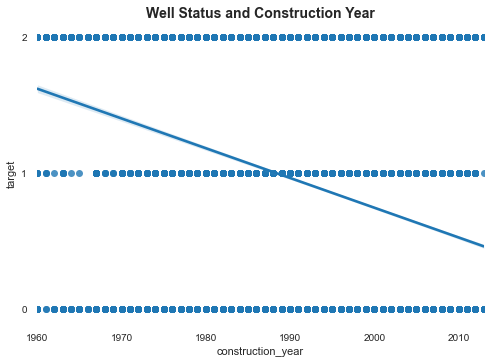

In [71]:
# definitely a strong relationship
fig, ax = plt.subplots(1)
sns.regplot(x='construction_year', y='target', data=df[(df['construction_year'] > 0)], ax=ax)
ax.set_yticks([0, 1, 2])
plt.title('Well Status and Construction Year', fontsize=14, fontweight='bold');

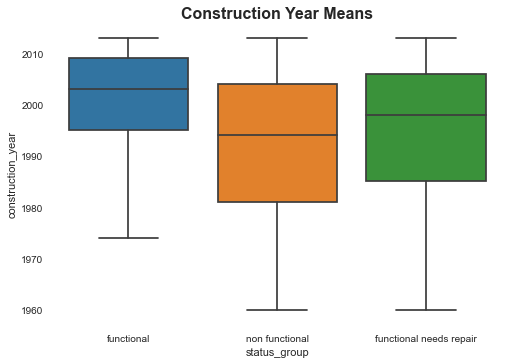

In [54]:
sns.boxplot(x='status_group',y='construction_year', data=df[df['construction_year'] > 0], showfliers=False)
plt.title('Construction Year Means', fontsize=16, fontweight='bold');

## Visualize Map

In [28]:
import contextily as ctx
import geopandas

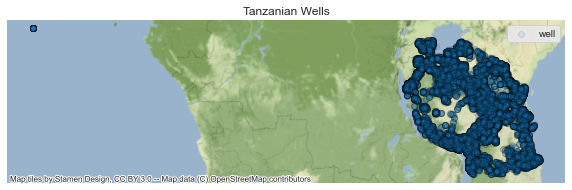

In [29]:
# create geopandas frames
gdf = geopandas.GeoDataFrame(
    df.copy(), geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

gdf = gdf.to_crs(epsg=3857)

# map the features using their geo coordinates
all_wells = gdf.plot(figsize=(10, 10), alpha=0.1, edgecolor='k', label='well')
plt.title('Tanzanian Wells')
plt.legend()
ctx.add_basemap(all_wells, source=ctx.providers.Stamen.TerrainBackground)
all_wells.set_axis_off()

WOW outliers. Some of the columns have missing coordinates.

In [30]:
gdf = gdf[gdf['longitude'] != 0]

### Wells by Status

In [31]:
gdf['status_group'].value_counts()

functional                 31389
non functional             22268
functional needs repair     3931
Name: status_group, dtype: int64

In [32]:
functional_gdf = gdf[gdf['status_group'] == 'functional']
non_functional_gdf = gdf[gdf['status_group'] == 'non functional']
needs_repair_gdf = gdf[gdf['status_group'] == 'functional needs repair']

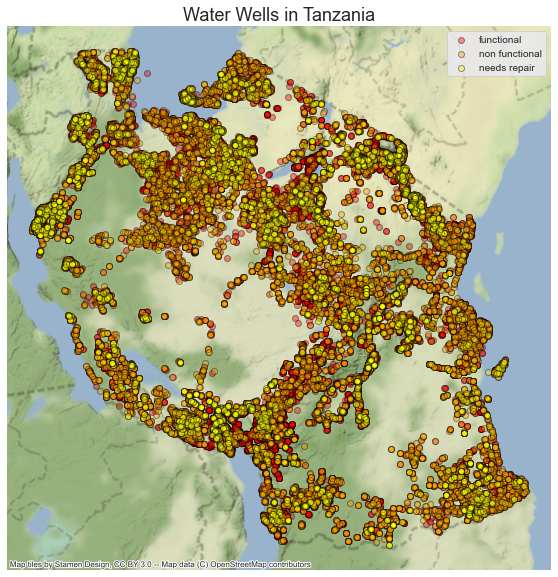

In [33]:
# map the features using their geo coordinates
wells_ax = functional_gdf.plot(figsize=(10, 10), alpha=0.4, edgecolor='k', label='functional', color='red')
wells_ax = non_functional_gdf.plot(ax=wells_ax, figsize=(10, 10), alpha=0.4, edgecolor='k', label='non functional', color='orange')
wells_ax = needs_repair_gdf.plot(ax=wells_ax, figsize=(10, 10), alpha=0.4, edgecolor='k', label='needs repair', color='yellow')

plt.legend()
plt.title('Water Wells in Tanzania', fontsize=18)
ctx.add_basemap(wells_ax, source=ctx.providers.Stamen.TerrainBackground)
wells_ax.set_axis_off()

### Wells by Year

In [34]:
construction_year_gdf = gdf[gdf['construction_year'] > 1900]

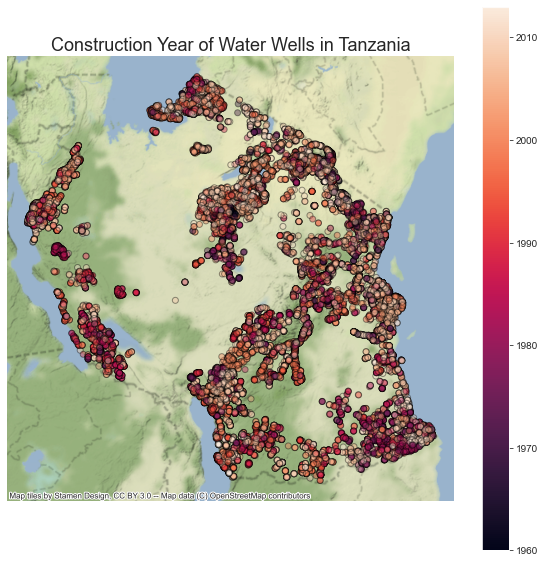

In [35]:
# map the features using their geo coordinates
wells_ax = construction_year_gdf.plot(column='construction_year', figsize=(10, 10), alpha=0.4, edgecolor='k', legend=True)
plt.title('Construction Year of Water Wells in Tanzania', fontsize=18)
ctx.add_basemap(wells_ax, source=ctx.providers.Stamen.TerrainBackground)
wells_ax.set_axis_off()

In [36]:
df.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [37]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report", minimal=True);

In [38]:
profile

In [45]:
biggie_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,target
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional,0
